In [1]:
import numpy as np
import pandas as pd

In [2]:
DATA_URI = "https://raw.githubusercontent.com/AlessandroGianfelici/danish_reviews_dataset/master/raw_data.txt"

In [3]:
dataf = pd.read_csv(DATA_URI, usecols=["review_text", "review_stars"])
dataf.sample(3)

,review_text,review_stars
17474,i burde have 0 stjerne jeg kan sjovt nok ikke ...,1
19838,"god service, super hurtig levering (24 timer),...",5
10097,Hurtig levering og gode priser samt et rigtig ...,5


In [4]:
(dataf
     .groupby(by=["review_stars"])
     .nunique()
     .sort_values(by="review_text", ascending=False)
     .rename(columns={"review_text": "review_count"})
     
)

,review_count
review_stars,
5,27945
1,8437
4,3170
2,1428
3,1172


In [5]:
(dataf
     .assign(sentiment = np.where(dataf["review_stars"].gt(3), 1, 0))
     .sample(10, random_state=42)
)

,review_text,review_stars,sentiment
19150,Dejligt man kan købe den rigtig størrelse når ...,5,1
6194,"nem hjemmeside, gode priser og hurtig levering",5,1
35684,"Har købt nærmest alt indenfor Bitz, da vi syne...",1,0
27361,Det var lige i skabet uden problemer. Super se...,5,1
35906,På forsiden af ugens reklame kunne man se at d...,2,0
21593,cpsms.dk leverer virkelig varen til en rigtig ...,5,1
26842,Det let at bestille og det hele godkendt inden...,5,1
14782,Super service og en rigtig god snak,5,1
11878,"God service og hurtig levering, jeg er fuldti...",5,1
6237,Top glasses fast delivery,5,1


In [10]:
datat = (dataf
     .assign(sentiment = np.where(dataf["review_stars"].gt(3), 1, 0))
     # .sample(10, random_state=42)
)

In [11]:
RANDOM_STATE = 42
(datat
     .assign(sentiment = np.where(dataf["review_stars"].gt(3), 1, 0))
     .sample(100, random_state=RANDOM_STATE)
     .index
)

Int64Index([19150,  6194, 35684, 27361, 35906, 21593, 26842, 14782, 11878,
             6237,  6366,  3933, 29534, 18636, 37134, 24775, 37485, 40922,
             7175, 41691, 27394, 43722, 41440,  9060, 33017, 37800,  6234,
            33131,  6244, 31033, 18094, 18491,   343, 11029, 33301, 19858,
             8541, 33348, 38990, 43832,   884,  2189, 33357, 42644, 11260,
            39990, 32610,  2746, 35265, 23420, 17792,   116, 13267, 42476,
            33393, 23068, 33157, 14600, 42026, 13956, 27984, 18578, 21954,
            12824, 11601, 24128, 31151, 22795, 37287, 14831, 32553, 15220,
            39947, 38222,  5525, 43567, 36585, 29395, 20196, 34174, 16504,
            12006, 23679,  4165,  4859,  3858, 19227, 32277, 23076, 26084,
             1673,  9162, 25704, 43924, 30777, 30827, 40119, 18237, 41948,
            17649],
           dtype='int64')

In [12]:
test_data_index = (datat
     .sample(100, random_state=RANDOM_STATE)
     .index
)

In [17]:
validation_data = datat.loc[test_data_index]

In [19]:
data = datat[~datat.index.isin(test_data_index)]

In [22]:
data.sample(5, random_state=42)

,review_text,review_stars,sentiment
10708,3. gang jeg leaser hos BMC. Intet negativt at ...,5,1
8164,Har ringet til jer 5 gange INDE i telefon tide...,4,1
19599,Vi har aldrig problemer med noget af det YouSe...,5,1
2533,Fuldt ud tilfreds!\n\nJeg har bestilt varer he...,5,1
25833,Vældigt god oplevelse med indlyttende og dygti...,5,1


In [34]:
(
    data[["sentiment"]]
     .value_counts()
     .rename(index ={0: "negative", 1:"positive"})
     .to_frame(name="observations")
     
)

,observations
sentiment,
positive,32958
negative,11027


In [137]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier

In [166]:
X, y = data["review_text"], data["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.9, 
                                                    random_state=42, 
                                                    stratify=y
                                                   )

In [167]:
(
    y_train.value_counts(normalize=True), 
    y_test.value_counts(normalize=True)
)

(1    0.749305
 0    0.250695
 Name: sentiment, dtype: float64,
 1    0.749261
 0    0.250739
 Name: sentiment, dtype: float64)

In [168]:
import re
def tokenizer(blob, stop_words=None, remove_digits=True):

    if stop_words is None:
        stop_words = {}
    
    blob = blob.lower()
    
     # eyes [nose] mouth | mouth [nose] eyes pattern
    emoticons = r"(?:[<>]?[:;=8][\-o\*\']?[\)\]\(\[dDpP/\:\}\{@\|\\]|[\)\]\(\[dDpP/\:\}\{@\|\\][\-o\*\']?[:;=8][<>]?)"
    emoticon_re = re.compile(emoticons, re.VERBOSE | re.I | re.UNICODE)
    
    text = re.sub(r'[\W]+', ' ', blob)
    
    # remove 3+ repetitive characters i.e. hellllo -> hello, jaaaa -> jaa 
    repetitions = re.compile(r'(.)\1{2,}')
    text = repetitions.sub(r'\1\1', text)
    
    # remove 2+ repetitive words e.g. hej hej hej -> hej
    
    repetitions = re.compile(r'\b(\w+)\s+(\1\s*)+\b')
    text = repetitions.sub(r'\1 ', text)
    
    
    emoji = ''.join(re.findall(emoticon_re, blob))
    
       
    # remove stopwords
    if stop_words:
        text = [word for word in text.split() if word not in stop_words]
    

    
    if remove_digits:
        text = re.sub(r'\b\d+\b', '', text)
    

    # remove extra spaces
    text = ' '.join(text.split())
    result = f'{text} {emoji}'.encode('utf-8').decode('utf-8')
       
    
    return result.split()

In [229]:
model = Pipeline(
    [
        ("tfidf", TfidfVectorizer(tokenizer=tokenizer, token_pattern=None, ngram_range=(1,2))),
        ("clf", SGDClassifier(loss="log")),
    ] 
)

In [230]:
model.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2), token_pattern=None,
                                 tokenizer=<function tokenizer at 0x7f23788d3940>)),
                ('clf', SGDClassifier(loss='log'))])

In [231]:
model.score(X_test, y_test)

0.927710843373494

In [232]:
y_pred = model.predict(X_test)

In [233]:
from sklearn.metrics import ConfusionMatrixDisplay

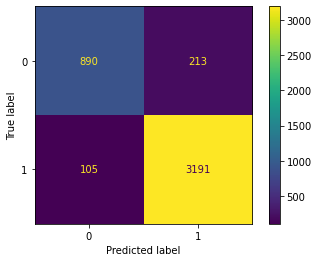

In [234]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

In [235]:
from sklearn.metrics import classification_report

In [236]:
print(classification_report(y_test, y_pred, target_names=["negative", "positive"]))

              precision    recall  f1-score   support

    negative       0.89      0.81      0.85      1103
    positive       0.94      0.97      0.95      3296

    accuracy                           0.93      4399
   macro avg       0.92      0.89      0.90      4399
weighted avg       0.93      0.93      0.93      4399



In [237]:
(
    validation_data
    .assign(score = lambda d: model.predict(d["review_text"]))
    .sample(10)
)

,review_text,review_stars,sentiment,score
9162,Bra side hvis man vil ha blader å abonnere på ...,5,1,1
26842,Det let at bestille og det hele godkendt inden...,5,1,1
3858,Hurtig ekspedition😄,5,1,1
14831,"Oplever som andre anmeldere her, at\n\nBestill...",1,0,0
43722,Havde bestilt et påskeæg til min kærestes datt...,1,0,0
42644,Jeg har uden tvivl mødt de mest omsorgsfulde o...,5,1,1
6194,"nem hjemmeside, gode priser og hurtig levering",5,1,1
18578,Supersmidig process med 100% flyt!,5,1,1
14600,På kort varsel fik jeg skiftet bremser og klod...,5,1,1
31151,PAS PÅ! Ingen service og svære at komme i kont...,1,0,0


In [238]:
(
    validation_data
    .assign(score = lambda d: model.predict(d["review_text"]))
    .loc[lambda d: d["sentiment"].ne(d["score"])]
)

,review_text,review_stars,sentiment,score
19150,Dejligt man kan købe den rigtig størrelse når ...,5,1,0
29534,Pakken kom 1 dag for sent end forventet i følg...,1,0,1
41440,Skulle have en Office licens. \nSmartworld hav...,5,1,0
33017,"Som flere oplever, meget dårlig beskrevne effe...",1,0,1
37800,"Igennem vores boligjagt, har vi været til mang...",1,0,1
43832,Jeg gik ind på deres hjemmeside for at bestill...,5,1,0
33393,"Prisen er god, og bestilte derfor 2 par sko ti...",1,0,1
13956,"Medarbejderne knokler, der er alt for få til a...",2,0,1
37287,Jeg er fint tilfreds med POWER og deres meget ...,3,0,1
32553,"Manglende udvikling af mobilbank. JyskeBanks ""...",1,0,1


In [240]:
(
    validation_data
    .assign(score = lambda d: model.predict(d["review_text"]))
    .loc[lambda d: d["sentiment"].ne(d["score"])]
    .assign(score_probability = lambda d: model.predict_proba(d["review_text"])[:, 1])
)

,review_text,review_stars,sentiment,score,score_probability
19150,Dejligt man kan købe den rigtig størrelse når ...,5,1,0,0.485033
29534,Pakken kom 1 dag for sent end forventet i følg...,1,0,1,0.754157
41440,Skulle have en Office licens. \nSmartworld hav...,5,1,0,0.498780
33017,"Som flere oplever, meget dårlig beskrevne effe...",1,0,1,0.584242
37800,"Igennem vores boligjagt, har vi været til mang...",1,0,1,0.591016
43832,Jeg gik ind på deres hjemmeside for at bestill...,5,1,0,0.488189
33393,"Prisen er god, og bestilte derfor 2 par sko ti...",1,0,1,0.500002
13956,"Medarbejderne knokler, der er alt for få til a...",2,0,1,0.515863
37287,Jeg er fint tilfreds med POWER og deres meget ...,3,0,1,0.573817
32553,"Manglende udvikling af mobilbank. JyskeBanks ""...",1,0,1,0.574315


In [257]:
model.named_steps["clf"].coef_[0]

array([ 0.01791708, -0.02013702, -0.0014755 , ..., -0.06055644,
        0.01028992,  0.01028992])

In [254]:
model.named_steps["tfidf"].get_feature_names_out()

array(['(-:', '(8', '(8:-)', ..., 'øøvv', 'жre', 'жre medlem'],
      dtype=object)

In [267]:
explain = (
        pd
            .DataFrame({"score":model.named_steps["clf"].coef_[0]},
                       index = model.named_steps["tfidf"].get_feature_names_out()
            )
            .sort_values(by="score")
)

In [271]:
explain.head(3), explain.tail(3)

(            score
 ikke   -10.065009
 dårlig  -5.890535
 at      -3.924502,
            score
 hurtig  4.997415
 super   5.409145
 god     5.851818)

In [282]:
(
    validation_data
    .assign(score = lambda d: model.predict(d["review_text"]))
    .loc[lambda d: d["sentiment"].ne(d["score"])]
    .assign(score_probability = lambda d: model.predict_proba(d["review_text"])[:, 1])
    .loc[lambda d: (d["score"].eq(0) & d["score_probability"].lt(.4))]
    # .loc[lambda d: (d["score"].eq(1) & d["score_probability"].gt(.6))]
)

,review_text,review_stars,sentiment,score,score_probability
26084,Kørte på motorvejen ved Horsens og fik en fejl...,5,1,0,0.281368


In [285]:
message = (
    validation_data
    .assign(score = lambda d: model.predict(d["review_text"]))
    .loc[lambda d: d["sentiment"].ne(d["score"])]
    .assign(score_probability = lambda d: model.predict_proba(d["review_text"])[:, 1])
    .loc[lambda d: (d["score"].eq(0) & d["score_probability"].lt(.4))]
    # .loc[lambda d: (d["score"].eq(1) & d["score_probability"].gt(.6))]
)["review_text"].squeeze()

In [301]:
message

'Kørte på motorvejen ved Horsens og fik en fejl på motoren. Jeg ringede og de lovede akut at sætte en tester på for at udlæse fejl. Det gjorde de, fin service, men desværre blokerede en leverandørlastbil så bilen ikke kunne komme ud af værkstedet. Det var jo ikke RAF’s skyld, men fordi jeg måtte vente 20-25 minutter ønskede de ikke betaling. Her kommer jeg gerne igen.'

In [300]:
explain[explain.index.isin(pd.Index(tokenizer(message)))]

,score
ikke,-10.065009
at,-3.924502
men,-3.889091
på,-3.462407
de,-2.999406
for,-2.735808
af,-1.868363
så,-1.618559
det,-1.213392
desværre,-1.176729


In [303]:
import sys

!{sys.executable} -m pip install hisia --quiet

In [304]:
import hisia

/home/pwd/.cache/pypoetry/virtualenvs/sentiment-h7wduh4z-py3.8/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/pwd/.cache/pypoetry/virtualenvs/sentiment-h7wduh4z-py3.8/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SelectKBest from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/pwd/.cache/pypoetry/virtualenvs/sentiment-h7wduh4z-py3.8/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying 

In [306]:
hisia.Hisia(message)

Sentiment(sentiment=negative, positive_probability=0.402, negative_probability=0.598)

In [307]:
hisia.Hisia("det er ikke ok")

Sentiment(sentiment=negative, positive_probability=0.013, negative_probability=0.987)

In [309]:
model.predict_proba(["det er ikke ok"]) # 0 - negative, 1 - positive

array([[0.85251729, 0.14748271]])

In [310]:
message2 = (
    validation_data
    .assign(score = lambda d: model.predict(d["review_text"]))
    .loc[lambda d: d["sentiment"].ne(d["score"])]
    .assign(score_probability = lambda d: model.predict_proba(d["review_text"])[:, 1])
    # .loc[lambda d: (d["score"].eq(0) & d["score_probability"].lt(.4))]
    .loc[lambda d: (d["score"].eq(1) & d["score_probability"].gt(.6))]
)["review_text"].squeeze()

In [311]:
message2

'Pakken kom 1 dag for sent end forventet i følge leveringen. Det var den var en stor del af de fødselsdagsgaver min søn skulle have. De andre gaver jeg havde bestilt samme dag var kommet til tiden. Så det blev en ærgelig oplevelse'

In [328]:
LOWER_BOUND, UPPER_BOUND = 0.35, 0.65
(
    validation_data
    .assign(score_probability = lambda d: model.predict_proba(d["review_text"])[:, 1],
            score = lambda d: np.where(d["score_probability"].gt(.5), 1, 0))
    .loc[lambda d: (d["score_probability"].gt(LOWER_BOUND) & d["score_probability"].lt(UPPER_BOUND))]
)

,review_text,review_stars,sentiment,score_probability,score
19150,Dejligt man kan købe den rigtig størrelse når ...,5,1,0.485033,0
41440,Skulle have en Office licens. \nSmartworld hav...,5,1,0.498780,0
33017,"Som flere oplever, meget dårlig beskrevne effe...",1,0,0.584242,1
37800,"Igennem vores boligjagt, har vi været til mang...",1,0,0.591016,1
343,Den ene af to bøger ankom med tydelige ‘slåede...,2,0,0.364247,0
43832,Jeg gik ind på deres hjemmeside for at bestill...,5,1,0.488189,0
35265,Færdig med at vente 🙂\nFinder min oprindelige ...,1,0,0.451602,0
33393,"Prisen er god, og bestilte derfor 2 par sko ti...",1,0,0.500002,1
13956,"Medarbejderne knokler, der er alt for få til a...",2,0,0.515863,1
37287,Jeg er fint tilfreds med POWER og deres meget ...,3,0,0.573817,1
